# Imágenes Biomédicas. Proyecto 0.

**Diego Moreno**

Importamos librerías necesarias:

In [42]:
import dipy
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

Leemos la imagen

In [6]:
img = nib.load('20181018_140750T1T2mapRAREs60001a001.nii')

In [57]:
img.shape

(230, 180, 30)

In [270]:
img_data = img.get_fdata()
img_aff  = img.affine
img_hdr  = img.header

#print(img_hdr,'\n\n', img_aff, '\n')

Mostramos los 30 cortes del cerebro de la rata:

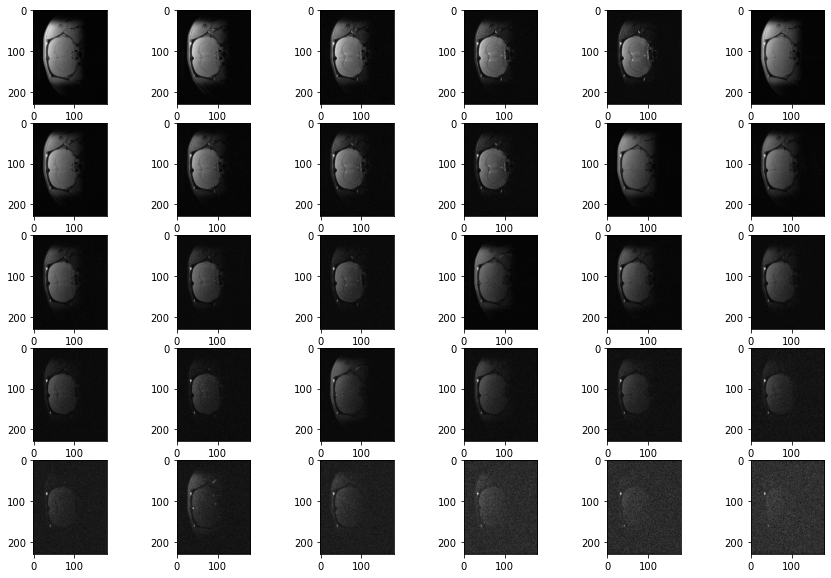

In [26]:
plt.figure(figsize=(15,10))
count = 0
if len(img_data.shape) == 3:
    for slice_Number in range(img_data.shape[2]):
        plt.subplot2grid((5,6),(count//6, slice_Number%6))
        plt.imshow(img_data[:, :, slice_Number], cmap='Greys_r')
        count += 1
    plt.show()

Vamos a seleccionar solo los píxeles de mayor varianza:

In [91]:
mask = np.var(img_data, axis=2)

In [92]:
def ridler_calvard(img, tolerance=0.001, n=256):
    img_aux = img*n
    m = np.mean(img_aux) # Initial estimation of the mean
    new_thresh = m
    while(1):
        prev_thresh = new_thresh
        threshold = round(prev_thresh)
        mb = np.mean(img_aux[img_aux <= threshold])
        mo = np.mean(img_aux[img_aux > threshold])
        new_thresh = (mb+mo)/2
        if abs(new_thresh-prev_thresh) <= tolerance:
            break
    return threshold/n

In [93]:
threshold = ridler_calvard(mask)
print('La frontera de umbralización encontrada es:\n%f\n' % threshold)
mask = mask >= threshold-50

La frontera de umbralización encontrada es:
82.593750



Imagen generada con el threshold


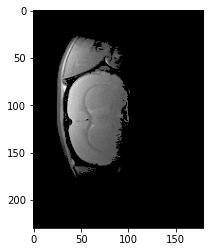

In [99]:
numero_imagen = 1
print('Imagen generada con el threshold')
img_aux = np.zeros(mask.shape, dtype=np.float64)
img_aux[mask] = img_data[mask, numero_imagen]
plt.imshow(img_aux, 'Greys_r')
plt.show()

Ahora leemos los datos de de los valores de TR y TE:

In [39]:
pth = ''
X_train = pd.read_csv(pth+'tabla_TR_TE_values.csv',  engine='python').values.tolist()
X_train = np.array(X_train)

In [ ]:
TR = X_train[:, 1]
TE = X_train[:, 2]

Definimos la función $f_{T_1}$ y $f_{T_2}$ y la suma de ambas $f$:

In [171]:
def f_T1(tr, M_0, T1):
    return M_0 * (1-np.exp(-tr/T1))

def f_T2(te, M_0, T2):
    return M_0 * (np.exp(-te/T2))

def f(x, M_0, T1, T2):
    ans = 1 + np.exp(-x[1]/T2) - np.exp(-x[0]/T1)
    ans *= M_0 / 2
    return ans

Ajustamos los modelos por vóxel:

In [173]:
M = [img_data[mask, num_img] for num_img in range(img_data.shape[2])]
M = np.array(M)

xdata_TR = np.zeros(M.shape, dtype=np.float64)
xdata_TE = np.zeros(M.shape, dtype=np.float64)
for i in range(img_data.shape[2]):
    xdata_TR[i] = TR[i]
    xdata_TE[i] = TE[i]
ydata = M

(30, 7688)


# Primero obtenemos $M_0$ por vóxel, promediando los resultados de $f_{T_1}$ y $f_{T_2}$:

In [210]:
M0_T1_list = []
M0_T2_list = []
for i in range(ydata.shape[1]):
    popt, pcov = curve_fit(f_T1, xdata_TR[:,i], ydata[:,i], bounds=(0, [200., 5000.]))
    M0_T1_list.append(popt[1])
    popt, pcov = curve_fit(f_T2, xdata_TE[:,i], ydata[:,i], bounds=(0, [200., 500.]))
    M0_T2_list.append(popt[1])

M0_T1_list = np.array(M0_T1_list)
M0_T2_list = np.array(M0_T2_list)

Obtenemos $M_0$ por vóxel:

In [242]:
M0 = np.mean(np.array([M0_T1_list, M0_T2_list]), axis=0)
M0 = np.array([M0 for i in range(xdata_TR.shape[0])]).T

Ahora encontramos los $T_1$ y $T_2$ por vóxel con el $M_0$ ya encontrado anteriormente:

In [243]:
def f_T1_M0(tr, T1):
    return M0[count] * (1-np.exp(-tr/T1))

def f_T2_M0(te, T2):
    return M0[count] * (np.exp(-te/T2))

In [267]:
T1_list = []
T2_list = []
count = 0
for i in range(ydata.shape[1]):
    count = i
    popt, pcov = curve_fit(f_T1_M0, xdata_TR[:,i], ydata[:,i], bounds=(0, 5000.))
    T1_list.append(popt[0])
    popt, pcov = curve_fit(f_T2_M0, xdata_TE[:,i], ydata[:,i], bounds=(0, 500.))
    T2_list.append(popt[0])

T1_list = np.array(T1_list)
T2_list = np.array(T2_list)

Imprimimos una imagen del mapa T1:

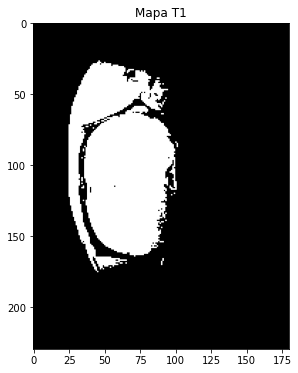

In [268]:
plt.figure(figsize=(6,6))
img_aux = np.zeros(img_data[:,:,0].shape, dtype=np.float64)
img_aux[mask] = T1_list
plt.title('Mapa T1')
plt.imshow(img_aux, 'Greys_r')
plt.show()

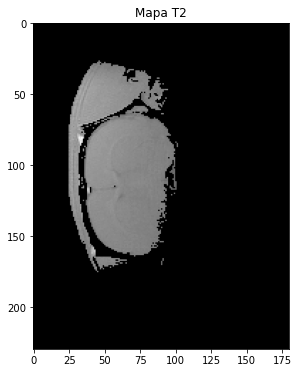

In [269]:
plt.figure(figsize=(6,6))
img_aux = np.zeros(img_data[:,:,0].shape, dtype=np.float64)
img_aux[mask] = T2_list
plt.title('Mapa T2')
plt.imshow(img_aux, 'Greys_r')
plt.show()

Notamos que los resultados no son muy buenos puesto que $T_1$ no se encuentra un optimo y está todo blanco. Procedemos con otra estrategia.

# Encontramos los mapas optimizando tanto para $M_0$ como $T_1$ y $T_2$ por vóxel.

In [261]:
T1_list = []
T2_list = []
for i in range(ydata.shape[1]):
    popt, pcov = curve_fit(f_T1, xdata_TR[:,i], ydata[:,i], bounds=(0, [200., 5000.]))
    T1_list.append(popt[1])
    popt, pcov = curve_fit(f_T2, xdata_TE[:,i], ydata[:,i], bounds=(0, [200., 500.]))
    T2_list.append(popt[1])

T1_list = np.array(T1_list)
T2_list = np.array(T2_list)

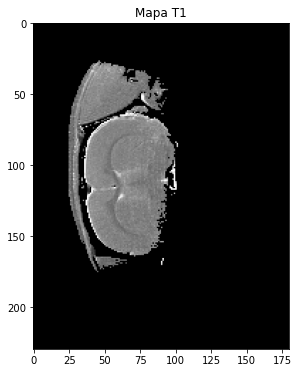

In [265]:
plt.figure(figsize=(6,6))
img_aux = np.zeros(img_data[:,:,0].shape, dtype=np.float64)
img_aux[mask] = T1_list
plt.title('Mapa T1')
plt.imshow(img_aux, 'Greys_r')
plt.show()

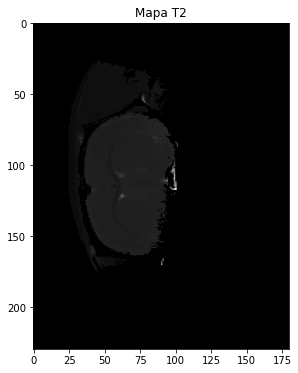

In [266]:
plt.figure(figsize=(6,6))
img_aux = np.zeros(img_data[:,:,0].shape, dtype=np.float64)
img_aux[mask] = T2_list
plt.title('Mapa T2')
plt.imshow(img_aux, 'Greys_r')
plt.show()

# A continuación, solo un experimento para visualizar la caída de magetización para todas las imágenes.

Valores posibles de $M_0, T_1, T_2$.

In [137]:
M = [img_data[mask, num_img] for num_img in range(img_data.shape[2])]
M = np.array(M)
M = M.reshape(-1)
long = M.shape[0]//img_data.shape[2]

xdata = np.zeros((2, M.shape[0]), dtype=np.float64)
for i in range(img_data.shape[2]):
    xdata[0, (i*long):((i+1)*long)] = TR[i]
    xdata[1, (i*long):((i+1)*long)] = TE[i]
ydata = M

Ajustamos la curva para encontrar los coeficientes correspondientes a $M_0, T_1, T_2$.

In [154]:
popt, pcov = curve_fit(f, xdata, ydata, bounds=(0, [200., 5000., 500.]))

In [155]:
popt

array([  46.43515575, 3305.0131386 ,   11.61809037])

In [160]:
x = np.linspace(0,500,1000)
M_0 = popt[0]
T_1 = popt[1]
T_2 = popt[2]

Visualizamos que tal está la caída por $T_1$ y  $T_2$.

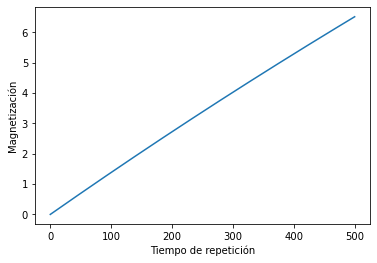

In [168]:
plt.plot(x, f_T1(x, M_0, T_1))
plt.xlabel('Tiempo de repetición')
plt.ylabel('Magnetización')
plt.show()

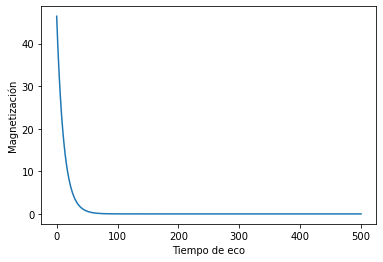

In [169]:
plt.plot(x, f_T2(x, M_0, T_2))
plt.xlabel('Tiempo de eco')
plt.ylabel('Magnetización')
plt.show()